In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import random_split, Dataset, DataLoader
import os.path as osp
from tqdm import tqdm
from PIL import Image

root = "/kaggle/input/food-classification"

print("Import thư viện thành công")

Import thư viện thành công


In [2]:
cwd = os.getcwd()
print(cwd)

/kaggle/working


In [3]:
# Thiet lap seed cho environment

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Đã thiết lập seed = {seed} thành công")

SEED = 42
set_seed(SEED)

Đã thiết lập seed = 42 thành công


In [4]:
#Dinh nghia ham transform

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])

])

val_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225]),

])

print("Da dinh nghia ham transform thanh cong")

Da dinh nghia ham transform thanh cong


In [5]:
#Tao dataset
class FoodData(data.Dataset):
    def __init__(self, root_dir, transform=None, is_test=False):
        self.root_dir = root_dir
        self.img_folder = osp.join(root, root_dir, 'images')
        self.transform = transform
        self.is_test = is_test

        if is_test:
            self.annotations = pd.read_csv(osp.join(root, root_dir, "test_mapping.csv"))
        else:
            self.annotations = pd.read_csv(osp.join(root, root_dir, "label.csv"))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        row = self.annotations.iloc[idx]
        img_path = osp.join(self.img_folder, row['image_name'])
        image = Image.open(img_path).convert("RGB")

        if self.transform:  # Apply the transform here
            image = self.transform(image)

        if self.is_test:
            return image, -1

        else:
            label = int(row['label'])
            return image, label

## ResNet50 from scratch

In [6]:
class block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(block, self).__init__()
        self.expansion = 4

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.act2 = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.act3 = nn.ReLU()

    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.act3(x)
        return x


#Xay dung model Resnet:
class ResNet(nn.Module): #[3, 4, 6, 3]
    def __init__(self, block, layers, input_channels, num_classes):
        super(ResNet, self).__init__()

        self.in_channels = 64
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.act = nn.ReLU()
        self.maxpooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.dropout = nn.Dropout2d(p=0.2)
        #Create Layers
        self.layer1 = self._make_layer(block, layers[0], 64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], 128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], 256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], 512, stride=2)

        self.adppool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*4, num_classes)



    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.maxpooling(x)
        x = self.dropout(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)        
        x = self.layer4(x)
        x = self.adppool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        layers = []
        identity_downsample = None


        if stride!=1 or self.in_channels!= out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels*4, stride=stride, kernel_size=1),
                nn.BatchNorm2d(out_channels*4)
            )

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4

        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

In [7]:
def ResNet50(input_channels=3, num_classes=20):
    return ResNet(block, [3, 4, 6, 3], input_channels, num_classes)

In [8]:
# class EarlyStopping:
#     def __init__(self, patience=5, delta=0):
#         self.patience = patience
#         self.delta = delta
#         self.best_score = None
#         self.early_stop = False
#         self.counter = 0
#         self.best_model_state = None

#     def __call__(self, val_loss, model):
#         score = -val_loss

#         if self.best_score is None:
#             self.best_score = score
#             self.best_model_state = model.state_dict()
#         elif score < self.best_score + self.delta:
#             self.counter += 1
#             if self.counter >= self.patience:
#                 self.early_stop = True
#         else:
#             self.best_score = score
#             self.best_model_state = model.state_dict()
#             self.counter = 0

#     def load_best_model(self, model):
#         model.load_state_dict(self.best_model_state)

In [9]:
def worker_init_fn(worker_id):
    worker_seed = torch.initial_seed() %2 **32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

#Load dataset
# Pass the transform to the FoodData constructor
full_dataset = FoodData(root_dir="contest_data/train/", transform=train_transform)
train_size = int(len(full_dataset)*0.85)
val_size = int(len(full_dataset)-train_size)

print(f"Tổng số ảnh: {len(full_dataset)}")
print(f"Train: {train_size}, Validation: {val_size}")

Tổng số ảnh: 600
Train: 510, Validation: 90


In [10]:
generator = torch.Generator().manual_seed(SEED)

train_dataset, val_dataset = random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

BATCH_SIZE = 25

#Load dataset

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    worker_init_fn=worker_init_fn,
    generator=generator,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    worker_init_fn=worker_init_fn,
    num_workers=2,
    pin_memory=True
)

print(f"Đã tạo DataLoader (batch_size={BATCH_SIZE})")

Đã tạo DataLoader (batch_size=25)


In [11]:
#7 Train model

#Thiet lap device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Da thiet lap device: {device}")

#Khoi tao model
model = ResNet50(num_classes=20)
# Move the model to the device
model.to(device)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Khoi tao loss va optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01, betas=(0.9, 0.95))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 100, 130], gamma=0.5)
# early_stopping = EarlyStopping(patience=5, delta=0.01)

#Hyper parameters:
NUM_EPOCHS = 120
print(f"Bat dau huan luyen: {NUM_EPOCHS} epochs")

#Luu history:
train_losss = []
val_losss = []
train_accc = []
val_accc = []

best_val_acc = 0.0
best_model_state = None

Da thiet lap device: cuda
Bat dau huan luyen: 120 epochs


In [12]:
for epoch in range(NUM_EPOCHS):
    #==============TRAINING PHASE==================
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch: {epoch+1}/{NUM_EPOCHS} [TRAIN]"):
        images = images.to(device)
        labels = labels.to(device)

        #Forward pass:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Thống kê
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = 100 * correct / len(train_loader.dataset)

    # ===== VALIDATION PHASE =====
    model.eval()
    val_correct, val_total = 0, 0
    val_running_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / len(val_loader.dataset)

    #Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    # Update learning rate
    scheduler.step()

    # Lưu history
    train_losss.append(train_loss)
    train_accc.append(train_acc)
    val_losss.append(val_loss)
    val_accc.append(val_acc)

    # In kết quả
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}]:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, LR: {scheduler.get_last_lr()[0]:.6f}\n")

#     early_stopping(val_loss, model)
#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

# early_stopping.load_best_model(model)
print("Hoàn thành huấn luyện!")

Epoch 1/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]



Epoch [1/120]:
  Train Loss: 3.9041, Train Acc: 4.51%
  Val Loss: 3.1158, Val Acc: 5.56%, LR: 0.001000



Epoch 2/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.94it/s]



Epoch [2/120]:
  Train Loss: 3.2300, Train Acc: 4.12%
  Val Loss: 12.6625, Val Acc: 4.44%, LR: 0.001000



Epoch 3/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.12it/s]



Epoch [3/120]:
  Train Loss: 3.2089, Train Acc: 5.88%
  Val Loss: 3.8887, Val Acc: 5.56%, LR: 0.001000



Epoch 4/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]



Epoch [4/120]:
  Train Loss: 3.0617, Train Acc: 7.45%
  Val Loss: 5.0918, Val Acc: 4.44%, LR: 0.001000



Epoch 5/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.55it/s]



Epoch [5/120]:
  Train Loss: 3.0394, Train Acc: 7.45%
  Val Loss: 2.9830, Val Acc: 7.78%, LR: 0.001000



Epoch 6/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.27it/s]



Epoch [6/120]:
  Train Loss: 3.0162, Train Acc: 8.82%
  Val Loss: 3.0696, Val Acc: 5.56%, LR: 0.001000



Epoch 7/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.15it/s]



Epoch [7/120]:
  Train Loss: 3.1416, Train Acc: 10.00%
  Val Loss: 3.3008, Val Acc: 6.67%, LR: 0.001000



Epoch 8/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.42it/s]



Epoch [8/120]:
  Train Loss: 3.0918, Train Acc: 7.45%
  Val Loss: 3.1952, Val Acc: 4.44%, LR: 0.001000



Epoch 9/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.13it/s]



Epoch [9/120]:
  Train Loss: 3.0754, Train Acc: 5.88%
  Val Loss: 6.8154, Val Acc: 7.78%, LR: 0.001000



Epoch 10/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.09it/s]



Epoch [10/120]:
  Train Loss: 3.0013, Train Acc: 8.24%
  Val Loss: 3.7519, Val Acc: 8.89%, LR: 0.001000



Epoch 11/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.08it/s]



Epoch [11/120]:
  Train Loss: 3.0165, Train Acc: 9.02%
  Val Loss: 13.0006, Val Acc: 5.56%, LR: 0.001000



Epoch 12/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.07it/s]



Epoch [12/120]:
  Train Loss: 2.9441, Train Acc: 11.96%
  Val Loss: 7.3675, Val Acc: 12.22%, LR: 0.001000



Epoch 13/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.33it/s]



Epoch [13/120]:
  Train Loss: 2.8880, Train Acc: 10.20%
  Val Loss: 3.0049, Val Acc: 11.11%, LR: 0.001000



Epoch 14/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]



Epoch [14/120]:
  Train Loss: 2.9213, Train Acc: 11.18%
  Val Loss: 3.3170, Val Acc: 4.44%, LR: 0.001000



Epoch 15/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.83it/s]



Epoch [15/120]:
  Train Loss: 2.8892, Train Acc: 11.76%
  Val Loss: 3.0303, Val Acc: 12.22%, LR: 0.001000



Epoch 16/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]



Epoch [16/120]:
  Train Loss: 2.8547, Train Acc: 10.59%
  Val Loss: 3.5479, Val Acc: 11.11%, LR: 0.001000



Epoch 17/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]



Epoch [17/120]:
  Train Loss: 2.8397, Train Acc: 12.55%
  Val Loss: 3.0651, Val Acc: 10.00%, LR: 0.001000



Epoch 18/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]



Epoch [18/120]:
  Train Loss: 2.8378, Train Acc: 9.22%
  Val Loss: 2.9544, Val Acc: 10.00%, LR: 0.001000



Epoch 19/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]



Epoch [19/120]:
  Train Loss: 2.8506, Train Acc: 12.35%
  Val Loss: 3.0842, Val Acc: 7.78%, LR: 0.001000



Epoch 20/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]



Epoch [20/120]:
  Train Loss: 2.8223, Train Acc: 10.78%
  Val Loss: 2.9574, Val Acc: 10.00%, LR: 0.001000



Epoch 21/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]



Epoch [21/120]:
  Train Loss: 2.8425, Train Acc: 12.35%
  Val Loss: 3.8119, Val Acc: 8.89%, LR: 0.001000



Epoch 22/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]



Epoch [22/120]:
  Train Loss: 2.8148, Train Acc: 12.55%
  Val Loss: 2.8250, Val Acc: 15.56%, LR: 0.001000



Epoch 23/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.87it/s]



Epoch [23/120]:
  Train Loss: 2.8001, Train Acc: 11.57%
  Val Loss: 3.1530, Val Acc: 11.11%, LR: 0.001000



Epoch 24/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  7.00it/s]



Epoch [24/120]:
  Train Loss: 2.8306, Train Acc: 13.53%
  Val Loss: 3.1254, Val Acc: 11.11%, LR: 0.001000



Epoch 25/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]



Epoch [25/120]:
  Train Loss: 2.8071, Train Acc: 14.51%
  Val Loss: 3.4551, Val Acc: 8.89%, LR: 0.001000



Epoch 26/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]



Epoch [26/120]:
  Train Loss: 2.7676, Train Acc: 14.51%
  Val Loss: 3.0686, Val Acc: 10.00%, LR: 0.001000



Epoch 27/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]



Epoch [27/120]:
  Train Loss: 2.7542, Train Acc: 17.06%
  Val Loss: 2.9050, Val Acc: 6.67%, LR: 0.001000



Epoch 28/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.73it/s]



Epoch [28/120]:
  Train Loss: 2.7698, Train Acc: 14.31%
  Val Loss: 2.8999, Val Acc: 8.89%, LR: 0.001000



Epoch 29/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]



Epoch [29/120]:
  Train Loss: 2.7643, Train Acc: 14.90%
  Val Loss: 3.0080, Val Acc: 8.89%, LR: 0.001000



Epoch 30/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]



Epoch [30/120]:
  Train Loss: 2.6696, Train Acc: 17.65%
  Val Loss: 2.8323, Val Acc: 13.33%, LR: 0.001000



Epoch 31/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.46it/s]



Epoch [31/120]:
  Train Loss: 2.6480, Train Acc: 16.47%
  Val Loss: 2.9842, Val Acc: 11.11%, LR: 0.001000



Epoch 32/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.26it/s]



Epoch [32/120]:
  Train Loss: 2.6105, Train Acc: 18.43%
  Val Loss: 2.8664, Val Acc: 11.11%, LR: 0.001000



Epoch 33/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]



Epoch [33/120]:
  Train Loss: 2.5948, Train Acc: 19.61%
  Val Loss: 2.8490, Val Acc: 16.67%, LR: 0.001000



Epoch 34/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]



Epoch [34/120]:
  Train Loss: 2.6021, Train Acc: 19.80%
  Val Loss: 3.0267, Val Acc: 8.89%, LR: 0.001000



Epoch 35/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]



Epoch [35/120]:
  Train Loss: 2.5829, Train Acc: 19.02%
  Val Loss: 2.8866, Val Acc: 15.56%, LR: 0.001000



Epoch 36/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]



Epoch [36/120]:
  Train Loss: 2.5268, Train Acc: 20.59%
  Val Loss: 2.8332, Val Acc: 12.22%, LR: 0.001000



Epoch 37/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]



Epoch [37/120]:
  Train Loss: 2.4244, Train Acc: 24.71%
  Val Loss: 3.1125, Val Acc: 7.78%, LR: 0.001000



Epoch 38/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]



Epoch [38/120]:
  Train Loss: 2.4783, Train Acc: 23.73%
  Val Loss: 3.1958, Val Acc: 8.89%, LR: 0.001000



Epoch 39/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]



Epoch [39/120]:
  Train Loss: 2.4368, Train Acc: 22.94%
  Val Loss: 2.8619, Val Acc: 14.44%, LR: 0.001000



Epoch 40/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]



Epoch [40/120]:
  Train Loss: 2.3533, Train Acc: 27.06%
  Val Loss: 2.8767, Val Acc: 13.33%, LR: 0.001000



Epoch 41/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]



Epoch [41/120]:
  Train Loss: 2.3776, Train Acc: 24.51%
  Val Loss: 2.8701, Val Acc: 10.00%, LR: 0.001000



Epoch 42/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]



Epoch [42/120]:
  Train Loss: 2.3100, Train Acc: 26.27%
  Val Loss: 3.2181, Val Acc: 14.44%, LR: 0.001000



Epoch 43/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.76it/s]



Epoch [43/120]:
  Train Loss: 2.3399, Train Acc: 28.82%
  Val Loss: 2.9913, Val Acc: 13.33%, LR: 0.001000



Epoch 44/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]



Epoch [44/120]:
  Train Loss: 2.2435, Train Acc: 29.61%
  Val Loss: 3.1104, Val Acc: 14.44%, LR: 0.001000



Epoch 45/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]



Epoch [45/120]:
  Train Loss: 2.1596, Train Acc: 31.96%
  Val Loss: 3.0613, Val Acc: 11.11%, LR: 0.001000



Epoch 46/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]



Epoch [46/120]:
  Train Loss: 2.0622, Train Acc: 35.69%
  Val Loss: 3.2413, Val Acc: 14.44%, LR: 0.001000



Epoch 47/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]



Epoch [47/120]:
  Train Loss: 2.0609, Train Acc: 36.47%
  Val Loss: 3.0795, Val Acc: 21.11%, LR: 0.001000



Epoch 48/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]



Epoch [48/120]:
  Train Loss: 1.9963, Train Acc: 39.61%
  Val Loss: 3.2054, Val Acc: 15.56%, LR: 0.001000



Epoch 49/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]



Epoch [49/120]:
  Train Loss: 1.8408, Train Acc: 42.55%
  Val Loss: 3.3966, Val Acc: 17.78%, LR: 0.001000



Epoch 50/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.20it/s]



Epoch [50/120]:
  Train Loss: 1.8042, Train Acc: 44.71%
  Val Loss: 3.4207, Val Acc: 13.33%, LR: 0.001000



Epoch 51/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.52it/s]



Epoch [51/120]:
  Train Loss: 1.8327, Train Acc: 42.55%
  Val Loss: 3.1392, Val Acc: 16.67%, LR: 0.001000



Epoch 52/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.39it/s]



Epoch [52/120]:
  Train Loss: 1.7312, Train Acc: 46.08%
  Val Loss: 3.4500, Val Acc: 14.44%, LR: 0.001000



Epoch 53/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]



Epoch [53/120]:
  Train Loss: 1.5491, Train Acc: 51.57%
  Val Loss: 3.9079, Val Acc: 14.44%, LR: 0.001000



Epoch 54/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.70it/s]



Epoch [54/120]:
  Train Loss: 1.4369, Train Acc: 53.53%
  Val Loss: 3.6330, Val Acc: 18.89%, LR: 0.001000



Epoch 55/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]



Epoch [55/120]:
  Train Loss: 1.3618, Train Acc: 55.49%
  Val Loss: 3.7695, Val Acc: 20.00%, LR: 0.001000



Epoch 56/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]



Epoch [56/120]:
  Train Loss: 1.2378, Train Acc: 61.18%
  Val Loss: 3.9099, Val Acc: 14.44%, LR: 0.001000



Epoch 57/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.48it/s]



Epoch [57/120]:
  Train Loss: 1.2002, Train Acc: 63.14%
  Val Loss: 4.0668, Val Acc: 17.78%, LR: 0.001000



Epoch 58/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.38it/s]



Epoch [58/120]:
  Train Loss: 1.1942, Train Acc: 61.96%
  Val Loss: 4.1459, Val Acc: 16.67%, LR: 0.001000



Epoch 59/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.45it/s]



Epoch [59/120]:
  Train Loss: 1.0478, Train Acc: 66.47%
  Val Loss: 4.2835, Val Acc: 14.44%, LR: 0.001000



Epoch 60/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.78it/s]



Epoch [60/120]:
  Train Loss: 0.9771, Train Acc: 68.04%
  Val Loss: 4.5351, Val Acc: 12.22%, LR: 0.000500



Epoch 61/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]



Epoch [61/120]:
  Train Loss: 0.7466, Train Acc: 76.67%
  Val Loss: 4.3931, Val Acc: 13.33%, LR: 0.000500



Epoch 62/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.31it/s]



Epoch [62/120]:
  Train Loss: 0.5578, Train Acc: 84.12%
  Val Loss: 4.6966, Val Acc: 20.00%, LR: 0.000500



Epoch 63/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]



Epoch [63/120]:
  Train Loss: 0.4969, Train Acc: 84.90%
  Val Loss: 5.1851, Val Acc: 14.44%, LR: 0.000500



Epoch 64/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]



Epoch [64/120]:
  Train Loss: 0.4693, Train Acc: 84.31%
  Val Loss: 5.2877, Val Acc: 15.56%, LR: 0.000500



Epoch 65/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]



Epoch [65/120]:
  Train Loss: 0.4938, Train Acc: 85.29%
  Val Loss: 5.4634, Val Acc: 10.00%, LR: 0.000500



Epoch 66/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.58it/s]



Epoch [66/120]:
  Train Loss: 0.3992, Train Acc: 88.43%
  Val Loss: 5.4143, Val Acc: 6.67%, LR: 0.000500



Epoch 67/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]



Epoch [67/120]:
  Train Loss: 0.4805, Train Acc: 84.90%
  Val Loss: 5.5722, Val Acc: 10.00%, LR: 0.000500



Epoch 68/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]



Epoch [68/120]:
  Train Loss: 0.3445, Train Acc: 90.78%
  Val Loss: 4.9031, Val Acc: 12.22%, LR: 0.000500



Epoch 69/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]



Epoch [69/120]:
  Train Loss: 0.2852, Train Acc: 90.98%
  Val Loss: 5.3379, Val Acc: 18.89%, LR: 0.000500



Epoch 70/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]



Epoch [70/120]:
  Train Loss: 0.2480, Train Acc: 92.55%
  Val Loss: 5.5591, Val Acc: 17.78%, LR: 0.000500



Epoch 71/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]



Epoch [71/120]:
  Train Loss: 0.2144, Train Acc: 94.12%
  Val Loss: 5.9267, Val Acc: 18.89%, LR: 0.000500



Epoch 72/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.43it/s]



Epoch [72/120]:
  Train Loss: 0.3038, Train Acc: 90.39%
  Val Loss: 5.7508, Val Acc: 17.78%, LR: 0.000500



Epoch 73/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]



Epoch [73/120]:
  Train Loss: 0.2657, Train Acc: 91.96%
  Val Loss: 6.4343, Val Acc: 15.56%, LR: 0.000500



Epoch 74/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.44it/s]



Epoch [74/120]:
  Train Loss: 0.2676, Train Acc: 91.37%
  Val Loss: 5.5904, Val Acc: 17.78%, LR: 0.000500



Epoch 75/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]



Epoch [75/120]:
  Train Loss: 0.3465, Train Acc: 90.00%
  Val Loss: 6.1331, Val Acc: 17.78%, LR: 0.000500



Epoch 76/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]



Epoch [76/120]:
  Train Loss: 0.1948, Train Acc: 93.73%
  Val Loss: 6.1410, Val Acc: 11.11%, LR: 0.000500



Epoch 77/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]



Epoch [77/120]:
  Train Loss: 0.1906, Train Acc: 94.51%
  Val Loss: 6.5230, Val Acc: 14.44%, LR: 0.000500



Epoch 78/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]



Epoch [78/120]:
  Train Loss: 0.2373, Train Acc: 93.53%
  Val Loss: 6.7152, Val Acc: 16.67%, LR: 0.000500



Epoch 79/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]



Epoch [79/120]:
  Train Loss: 0.2428, Train Acc: 91.76%
  Val Loss: 6.0293, Val Acc: 14.44%, LR: 0.000500



Epoch 80/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]



Epoch [80/120]:
  Train Loss: 0.2978, Train Acc: 90.39%
  Val Loss: 5.9955, Val Acc: 16.67%, LR: 0.000500



Epoch 81/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]



Epoch [81/120]:
  Train Loss: 0.1849, Train Acc: 94.31%
  Val Loss: 5.5549, Val Acc: 20.00%, LR: 0.000500



Epoch 82/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.81it/s]



Epoch [82/120]:
  Train Loss: 0.2468, Train Acc: 92.16%
  Val Loss: 6.1805, Val Acc: 15.56%, LR: 0.000500



Epoch 83/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]



Epoch [83/120]:
  Train Loss: 0.1577, Train Acc: 96.08%
  Val Loss: 6.3578, Val Acc: 17.78%, LR: 0.000500



Epoch 84/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]



Epoch [84/120]:
  Train Loss: 0.1530, Train Acc: 95.88%
  Val Loss: 6.7141, Val Acc: 15.56%, LR: 0.000500



Epoch 85/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.56it/s]



Epoch [85/120]:
  Train Loss: 0.1233, Train Acc: 96.27%
  Val Loss: 6.2877, Val Acc: 18.89%, LR: 0.000500



Epoch 86/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.60it/s]



Epoch [86/120]:
  Train Loss: 0.1991, Train Acc: 93.14%
  Val Loss: 5.9258, Val Acc: 16.67%, LR: 0.000500



Epoch 87/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.25it/s]



Epoch [87/120]:
  Train Loss: 0.2026, Train Acc: 93.53%
  Val Loss: 6.8580, Val Acc: 12.22%, LR: 0.000500



Epoch 88/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.49it/s]



Epoch [88/120]:
  Train Loss: 0.2162, Train Acc: 91.76%
  Val Loss: 7.1009, Val Acc: 13.33%, LR: 0.000500



Epoch 89/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]



Epoch [89/120]:
  Train Loss: 0.2194, Train Acc: 94.12%
  Val Loss: 6.0101, Val Acc: 16.67%, LR: 0.000500



Epoch 90/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.65it/s]



Epoch [90/120]:
  Train Loss: 0.1180, Train Acc: 95.69%
  Val Loss: 6.2363, Val Acc: 18.89%, LR: 0.000500



Epoch 91/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.59it/s]



Epoch [91/120]:
  Train Loss: 0.1254, Train Acc: 96.27%
  Val Loss: 6.3780, Val Acc: 13.33%, LR: 0.000500



Epoch 92/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]



Epoch [92/120]:
  Train Loss: 0.1687, Train Acc: 94.12%
  Val Loss: 6.8785, Val Acc: 10.00%, LR: 0.000500



Epoch 93/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.68it/s]



Epoch [93/120]:
  Train Loss: 0.1588, Train Acc: 94.51%
  Val Loss: 7.2213, Val Acc: 12.22%, LR: 0.000500



Epoch 94/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]



Epoch [94/120]:
  Train Loss: 0.1623, Train Acc: 94.12%
  Val Loss: 7.1263, Val Acc: 14.44%, LR: 0.000500



Epoch 95/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.77it/s]



Epoch [95/120]:
  Train Loss: 0.1912, Train Acc: 94.31%
  Val Loss: 6.5730, Val Acc: 22.22%, LR: 0.000500



Epoch 96/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.03it/s]



Epoch [96/120]:
  Train Loss: 0.1564, Train Acc: 96.08%
  Val Loss: 6.7745, Val Acc: 11.11%, LR: 0.000500



Epoch 97/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]



Epoch [97/120]:
  Train Loss: 0.1079, Train Acc: 97.06%
  Val Loss: 6.7154, Val Acc: 18.89%, LR: 0.000500



Epoch 98/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.35it/s]



Epoch [98/120]:
  Train Loss: 0.1169, Train Acc: 96.67%
  Val Loss: 7.5479, Val Acc: 13.33%, LR: 0.000500



Epoch 99/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.40it/s]



Epoch [99/120]:
  Train Loss: 0.2277, Train Acc: 93.14%
  Val Loss: 6.8603, Val Acc: 16.67%, LR: 0.000500



Epoch 100/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]



Epoch [100/120]:
  Train Loss: 0.1271, Train Acc: 96.47%
  Val Loss: 7.1425, Val Acc: 15.56%, LR: 0.000250



Epoch 101/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.51it/s]



Epoch [101/120]:
  Train Loss: 0.1207, Train Acc: 97.45%
  Val Loss: 7.0433, Val Acc: 13.33%, LR: 0.000250



Epoch 102/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]



Epoch [102/120]:
  Train Loss: 0.1104, Train Acc: 97.25%
  Val Loss: 7.0546, Val Acc: 11.11%, LR: 0.000250



Epoch 103/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.53it/s]



Epoch [103/120]:
  Train Loss: 0.0514, Train Acc: 98.24%
  Val Loss: 7.1063, Val Acc: 15.56%, LR: 0.000250



Epoch 104/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.84it/s]



Epoch [104/120]:
  Train Loss: 0.0534, Train Acc: 98.43%
  Val Loss: 6.8771, Val Acc: 15.56%, LR: 0.000250



Epoch 105/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.61it/s]



Epoch [105/120]:
  Train Loss: 0.0963, Train Acc: 97.84%
  Val Loss: 6.7939, Val Acc: 12.22%, LR: 0.000250



Epoch 106/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.55it/s]



Epoch [106/120]:
  Train Loss: 0.0449, Train Acc: 98.82%
  Val Loss: 6.8156, Val Acc: 14.44%, LR: 0.000250



Epoch 107/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.66it/s]



Epoch [107/120]:
  Train Loss: 0.0344, Train Acc: 99.41%
  Val Loss: 6.8775, Val Acc: 16.67%, LR: 0.000250



Epoch 108/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]



Epoch [108/120]:
  Train Loss: 0.0455, Train Acc: 98.43%
  Val Loss: 7.2087, Val Acc: 13.33%, LR: 0.000250



Epoch 109/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.63it/s]



Epoch [109/120]:
  Train Loss: 0.0390, Train Acc: 99.02%
  Val Loss: 7.6016, Val Acc: 13.33%, LR: 0.000250



Epoch 110/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.75it/s]



Epoch [110/120]:
  Train Loss: 0.0493, Train Acc: 98.63%
  Val Loss: 7.2058, Val Acc: 12.22%, LR: 0.000250



Epoch 111/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.69it/s]



Epoch [111/120]:
  Train Loss: 0.0507, Train Acc: 98.43%
  Val Loss: 7.1652, Val Acc: 11.11%, LR: 0.000250



Epoch 112/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.36it/s]



Epoch [112/120]:
  Train Loss: 0.0440, Train Acc: 98.82%
  Val Loss: 7.3202, Val Acc: 18.89%, LR: 0.000250



Epoch 113/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.57it/s]



Epoch [113/120]:
  Train Loss: 0.0534, Train Acc: 98.43%
  Val Loss: 7.0924, Val Acc: 18.89%, LR: 0.000250



Epoch 114/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.62it/s]



Epoch [114/120]:
  Train Loss: 0.0581, Train Acc: 98.24%
  Val Loss: 7.1433, Val Acc: 20.00%, LR: 0.000250



Epoch 115/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]



Epoch [115/120]:
  Train Loss: 0.0364, Train Acc: 99.02%
  Val Loss: 7.1940, Val Acc: 16.67%, LR: 0.000250



Epoch 116/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.67it/s]



Epoch [116/120]:
  Train Loss: 0.0331, Train Acc: 99.22%
  Val Loss: 7.5676, Val Acc: 14.44%, LR: 0.000250



Epoch 117/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]



Epoch [117/120]:
  Train Loss: 0.0347, Train Acc: 98.43%
  Val Loss: 7.1459, Val Acc: 14.44%, LR: 0.000250



Epoch 118/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.23it/s]



Epoch [118/120]:
  Train Loss: 0.0289, Train Acc: 99.61%
  Val Loss: 7.0774, Val Acc: 14.44%, LR: 0.000250



Epoch 119/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.50it/s]



Epoch [119/120]:
  Train Loss: 0.0297, Train Acc: 99.22%
  Val Loss: 7.3664, Val Acc: 14.44%, LR: 0.000250



Epoch 120/120 [Val]: 100%|██████████| 4/4 [00:00<00:00,  6.72it/s]


Epoch [120/120]:
  Train Loss: 0.0302, Train Acc: 99.02%
  Val Loss: 7.4150, Val Acc: 11.11%, LR: 0.000250

Hoàn thành huấn luyện!


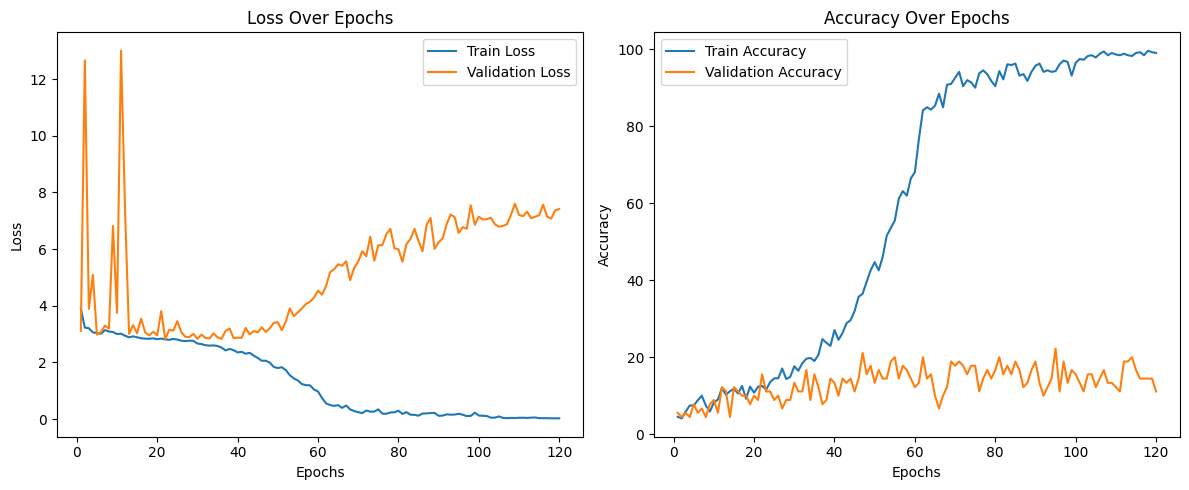

In [13]:
# Assuming train_losses, val_losses, train_accuracies, val_accuracies are lists storing the metrics
epochs = range(1, len(train_losss) + 1)

plt.figure(figsize=(12, 5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losss, label='Train Loss')
plt.plot(epochs, val_losss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accc, label='Train Accuracy')
plt.plot(epochs, val_accc, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [14]:
# 9. Inference trên Test Set

print("Bắt đầu inference trên TEST SET...")

# Load test dataset
test_dataset = FoodData(os.path.join(root, "contest_data/test/"), transform=val_transform, is_test=True)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Inference
model.load_state_dict(best_model_state)
model.eval()
# Change file_names to image_ids
image_ids = []
# Remove the is_negative prediction as it's not needed for this submission format
preds_category_id = []

with torch.no_grad():
    for i, (images, _) in enumerate(tqdm(test_loader, desc="Test Inference")):
        images = images.to(device)
        outputs = model(images)
        # Get the predicted class index
        _, predicted = outputs.max(1)

        # Get image IDs instead of file names
        batch_start = i * BATCH_SIZE
        batch_end = batch_start + images.size(0)
        # Assuming 'id' is the column name for image IDs in test_mapping.csv
        batch_ids = test_dataset.annotations.iloc[batch_start:batch_end]['ID'].values
        image_ids.extend(batch_ids)

        # Store the predicted category_id (which is the class index + 1 if class 0 is not used,
        # or directly the class index if class 0 is used for a food category)
        # Based on the label.csv, the labels are 0-19, so we store the predicted index directly.
        preds_category_id.extend(predicted.cpu().numpy())


# Tạo DataFrame kết quả
df_submission = pd.DataFrame({
    'ID': image_ids,  # Change column name to 'id'
    'label': preds_category_id
})

# Lưu file
submission_csv_path = os.path.join(cwd, "submission.csv") # Save to current working directory
df_submission.to_csv(submission_csv_path, index=False)
print(f"Đã tạo file submission.csv tại {submission_csv_path} với {len(df_submission)} dự đoán!")

# Hiển thị preview
print("\nPreview kết quả:")
print(df_submission.head(10))

Bắt đầu inference trên TEST SET...


Test Inference: 100%|██████████| 24/24 [00:07<00:00,  3.17it/s]

Đã tạo file submission.csv tại /kaggle/working/submission.csv với 600 dự đoán!

Preview kết quả:
   ID  label
0   1      9
1   2      9
2   3     19
3   4     10
4   5     12
5   6      3
6   7      2
7   8     19
8   9      4
9  10     17
